In [154]:
# Imports and Function Initialization

import numpy as np
import math
from math import log2, sqrt
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import Initialize
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram
import scipy.stats
import matplotlib.pyplot as plt
from qiskit.circuit.library import RYGate
from collections import deque
from qiskit_finance.circuit.library import LogNormalDistribution # qiskit version: >= 0.25  


def get_braket_string(statevector):
    '''
    Return a beautified string for the given statevector
    '''
    num_qubits = log2(len(statevector))
    assert num_qubits.is_integer(), 'Expected a 2**n state'
    num_qubits = int(num_qubits)
    
    assert abs(np.linalg.norm(statevector) - 1) < 1e-4, 'Norm of state is too far from 1'
    
    simpler_state = []
    # discards 0 values
    for amplitude in statevector:
        if amplitude.imag == 0 and amplitude.real == 0:
            simpler_state.append(0)
        elif amplitude.imag == 0:
            simpler_state.append(amplitude.real)
        elif amplitude.real == 0:
            simpler_state.append(amplitude.imag)
        else:
            simpler_state.append(amplitude)
    
    out_str = ''
    skip_plus = False
    for index, amplitude in enumerate(simpler_state):
        if amplitude == 0:
            skip_plus = True
            continue
        
        if not skip_plus and index > 0:
            out_str += '+'

        state = format(index, f'0{num_qubits}b')
        
        # g defaults to 6 digits of precision but ignores zeros        
        out_str += f'{amplitude : g}|{state}>'
    return out_str


In [155]:
# Define global variables for quantum state
num_qubits = 3
num_states = 2**num_qubits
state_step = 1 / num_states

# Define global variables for normal distribution
mean = 0.5
std = 1/6

In [156]:
# Get the discretized value for the normal distribution

p = []
for i in range(1, num_states + 1):
    state = i * state_step
    p.append(scipy.stats.norm.cdf(state, mean, std) - scipy.stats.norm.cdf(state - state_step, mean, std))

print(p)

[np.float64(0.010874574623414603), np.float64(0.05458272861381337), np.float64(0.15982015110801012), np.float64(0.2733726476231318), np.float64(0.27337264762313174), np.float64(0.15982015110801018), np.float64(0.054582728613813414), np.float64(0.010874574623414568)]


processing [np.float64(0.010874574623414603), np.float64(0.05458272861381337), np.float64(0.15982015110801012), np.float64(0.2733726476231318), np.float64(0.27337264762313174), np.float64(0.15982015110801018), np.float64(0.054582728613813414), np.float64(0.010874574623414568)] at [] with previous sum 1
processing [np.float64(0.010874574623414603), np.float64(0.05458272861381337), np.float64(0.15982015110801012), np.float64(0.2733726476231318)] at [True] with previous sum 0.4986501019683699
processing [np.float64(0.27337264762313174), np.float64(0.15982015110801018), np.float64(0.054582728613813414), np.float64(0.010874574623414568)] at [False] with previous sum 0.5013498980316301
processing [np.float64(0.010874574623414603), np.float64(0.05458272861381337)] at [True, True] with previous sum 0.06545730323722798
processing [np.float64(0.15982015110801012), np.float64(0.2733726476231318)] at [True, False] with previous sum 0.4331927987311419
processing [np.float64(0.27337264762313174), np

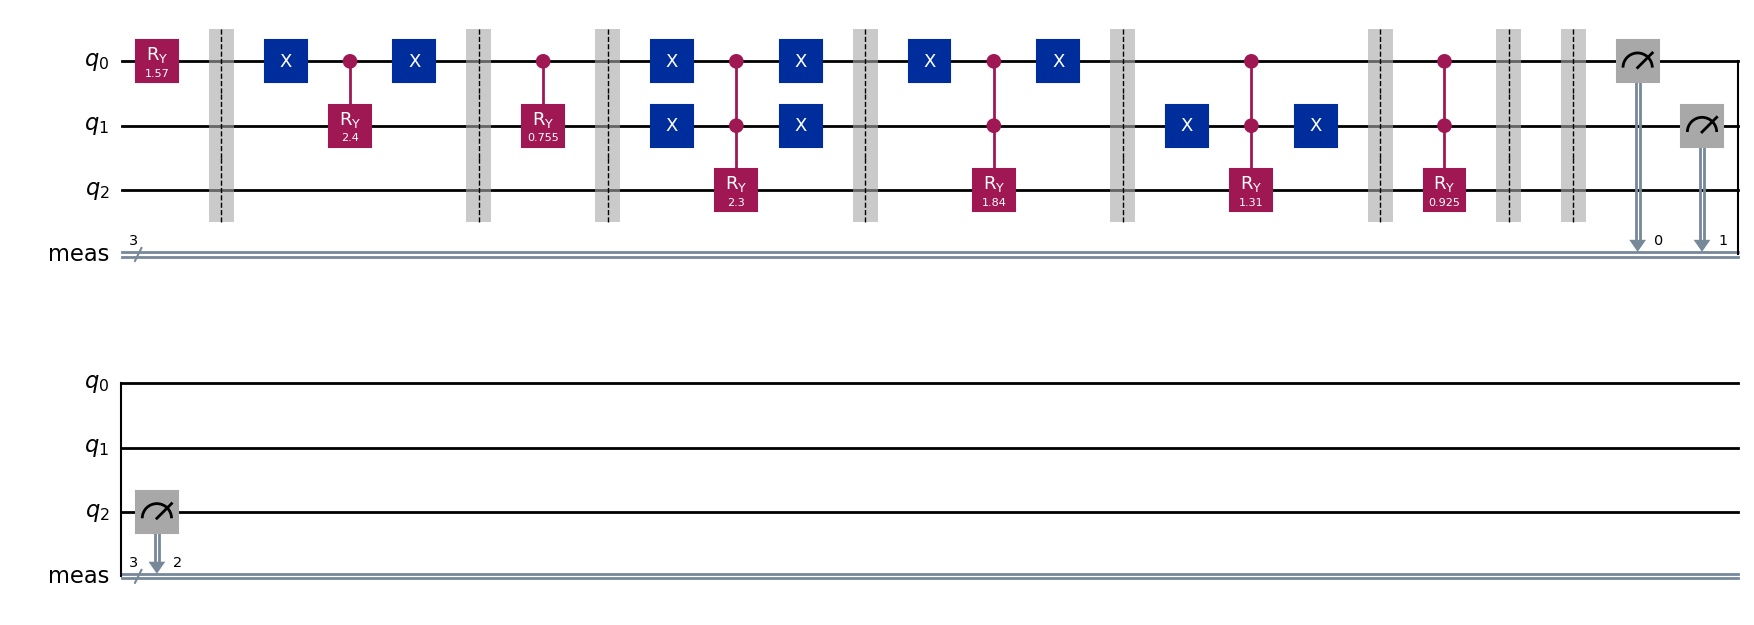

In [157]:
def create_circuit(p):
    qc = QuantumCircuit(num_qubits)

    queue = deque()
    queue.append((p, [], 1))

    while queue:
        curr_p, curr_path, prev_sum= queue.popleft()

        if (len(curr_p) == 1):
            continue
        
        print(f"processing {curr_p} at {curr_path} with previous sum {prev_sum}")

        mid = len(curr_p) // 2
        left_sum = sum(curr_p[:mid])
        theta = 2 * np.arccos(np.sum(sqrt(left_sum / prev_sum)))

        if (len(curr_path) == 0):
            qc.ry(theta, 0)
        else:
            not_gates = []
            for i in range(len(curr_path)):
                if curr_path[i]:
                    not_gates.append(i)
            qc.x(not_gates) if not_gates else None
            qc.append(RYGate(theta).control(len(curr_path)), list(range(len(curr_path) + 1)))
            qc.x(not_gates) if not_gates else None

        qc.barrier()
        
        queue.append((curr_p[:mid], curr_path + [True], left_sum))
        queue.append((curr_p[mid:], curr_path + [False], prev_sum - left_sum))

    qc.measure_all()
    return qc

qc = create_circuit(p)
qc.draw(output="mpl")

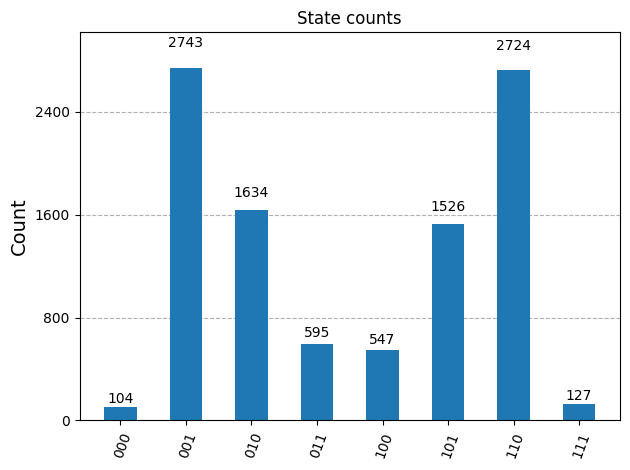

In [158]:
from qiskit_aer import AerSimulator

simulator = AerSimulator()
qc_t = transpile(qc, simulator)
result = simulator.run(qc_t,shots=10000).result()
counts = result.get_counts(qc_t)
plot_histogram(counts, title='State counts')